# Implementacja k-means

Zaimplementować swoją klasteryzację k-means i porównać ją z metodami wbudowanymi.

In [1]:
import numpy as np

In [2]:
import random
from scipy.cluster.vq import vq

def initial_centroids(X, k):
    initial = set()
    while len(initial) < k:
        initial.add(tuple(random.choice(X).tolist()))
    return np.array(list(initial))

def kmeans(X, k, max_iterations=np.inf):
    centroids = initial_centroids(X, k)
    finished = False
    iteration = 0
    codes_prev = np.zeros(X.shape[0])
    while not finished and iteration < max_iterations:
        # Assign each vector to cluster
        codes, dists = vq(X, centroids)
        # Find new centroids
        for i in range(k):
            centroids[i, :] = np.mean(X[codes == i], axis=0)
        
        if (codes == codes_prev).all():
            finished = True
            
        codes_prev = codes
        iteration += 1
    return codes.astype("int32"), centroids

In [3]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
Y = iris.target
Y_pred, centroids = kmeans(X, 3)
Y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2])

## Dopasowanie rezultatu klasteryzacji do rzeczywistych klas decyzyjnych

Poniższa funkcja wyszukuje najczęściej występującą wartość w `Y_real` pod kolejnymi indeksami spełnianymi przez `Y_pred`. Dzięki temu wektorowi `Y_pred` przyporządkowuje się poprawne oznaczenia klas.

In [4]:
import scipy

def find_perm(clusters, Y_real, Y_pred):
    perm=[]
    for i in range(clusters):
        idx = Y_pred == i
        new_label = scipy.stats.mode(Y_real[idx])[0][0]
        perm.append(new_label)
    return np.array([perm[label] for label in Y_pred])

Y_pred = find_perm(3, Y, Y_pred)
Y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1])

## Obliczenie indeksu Jaccarda

Indeks Jaccarda to statystyka do porównywania zbiorów. Mierzy podobieństwo między dwoma zbiorami. Jest zdefiniowany jako iloraz mocy części wspólnej zbiorów i mocy sumy tych zbiorów.

$$J(A, B)=\frac{|A \cap B|}{|A \cup B|}$$

Jeśli współczynnik Jaccarda przyjmuje wartości bliskie zeru, zbiory są od siebie różne, natomiast gdy jest bliski 1, zbiory są do siebie podobne.

In [5]:
from sklearn.metrics import jaccard_score

jaccard_scores = {}
score = jaccard_score(Y, Y_pred, average=None)
jaccard_scores["kmeans"] = score
score

array([1.        , 0.734375  , 0.67924528])

## Wizualizacja danych w przestrzeni 2D za pomocą metody PCA

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

In [7]:
# TODO convex hull
def plot_convex(data, y, ax):
    unique_labels = np.unique(y)
    for i in unique_labels:
        data_by_class = data[y == i, :]
        convex_hull = ConvexHull(data_by_class)
        for simplice in convex_hull.simplices:
            ax.plot(data_by_class[simplice, 0], data_by_class[simplice, 1], 'k')

Text(0.5, 1.0, 'Różnice')

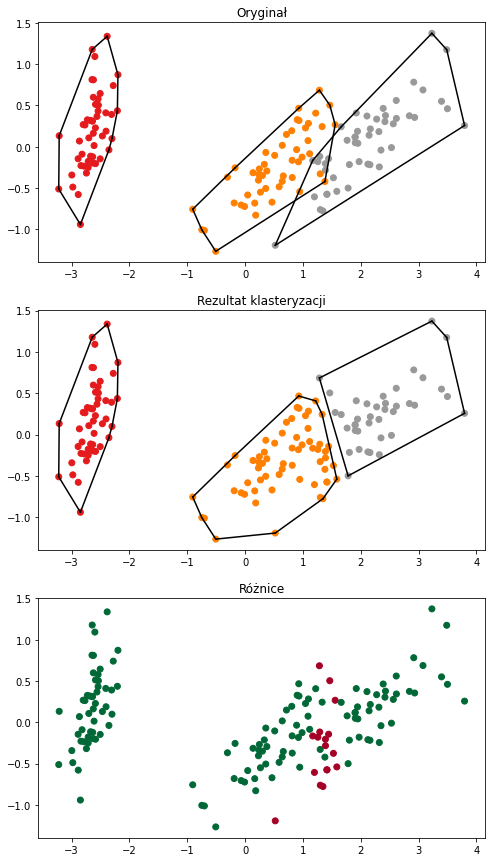

In [8]:
import matplotlib.pyplot as plt

from scipy.spatial import ConvexHull, convex_hull_plot_2d

fig, axes = plt.subplots(3, 1, figsize=(8, 15))
axes[0].scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y, cmap='Set1')
plot_convex(X_reduced, Y, axes[0])
axes[1].scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y_pred, cmap='Set1')
plot_convex(X_reduced, Y_pred, axes[1])
axes[2].scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y==Y_pred, cmap='RdYlGn')
axes[0].set_title("Oryginał")
axes[1].set_title("Rezultat klasteryzacji")
axes[2].set_title("Różnice")

Text(0.5, 0.92, 'Różnice')

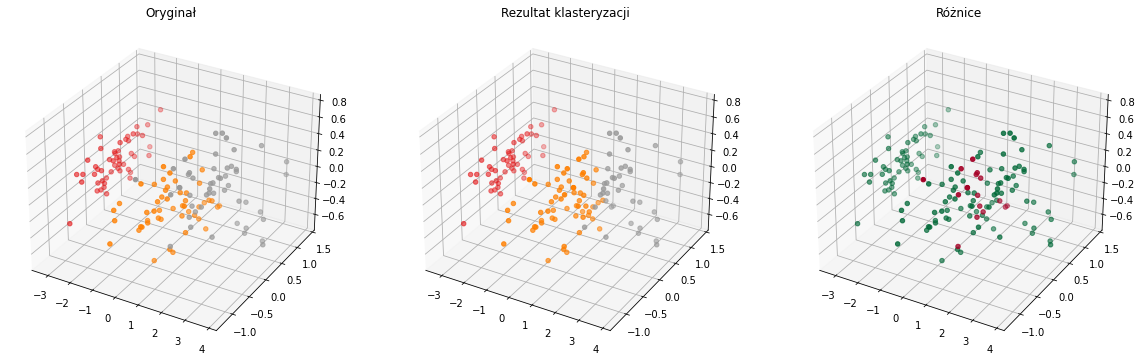

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X)

ax1.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y, cmap='Set1')
ax2.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y_pred, cmap='Set1')
ax3.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y==Y_pred, cmap='RdYlGn')
ax1.set_title("Oryginał")
ax2.set_title("Rezultat klasteryzacji")
ax3.set_title("Różnice")

## Metody wbudowane - `k-means`, `GMM`, `AgglomerativeClustering`

In [10]:
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from mpl_toolkits.mplot3d import Axes3D

def plot_reduction(X, Y, Y_pred):
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)
    
    fig = plt.figure(figsize=(20, 20))
    # 2D
    ax1 = fig.add_subplot(321)
    ax2 = fig.add_subplot(323)
    ax3 = fig.add_subplot(325)

    ax1.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y, cmap='Set1')
    plot_convex(X_reduced, Y, ax1)
    ax2.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y_pred, cmap='Set1')
    plot_convex(X_reduced, Y_pred, ax2)
    ax3.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y==Y_pred, cmap='RdYlGn')
    ax1.set_title("Oryginał")
    ax2.set_title("Rezultat klasteryzacji")
    ax3.set_title("Różnice")

    # 3D
    ax4 = fig.add_subplot(322, projection='3d')
    ax5 = fig.add_subplot(324, projection='3d')
    ax6 = fig.add_subplot(326, projection='3d')

    pca = PCA(n_components=3)
    X_reduced = pca.fit_transform(X)

    ax4.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y, cmap='Set1')
    ax5.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y_pred, cmap='Set1')
    ax6.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y==Y_pred, cmap='RdYlGn')
    ax4.set_title("Oryginał")
    ax5.set_title("Rezultat klasteryzacji")
    ax6.set_title("Różnice")

### `k-means`

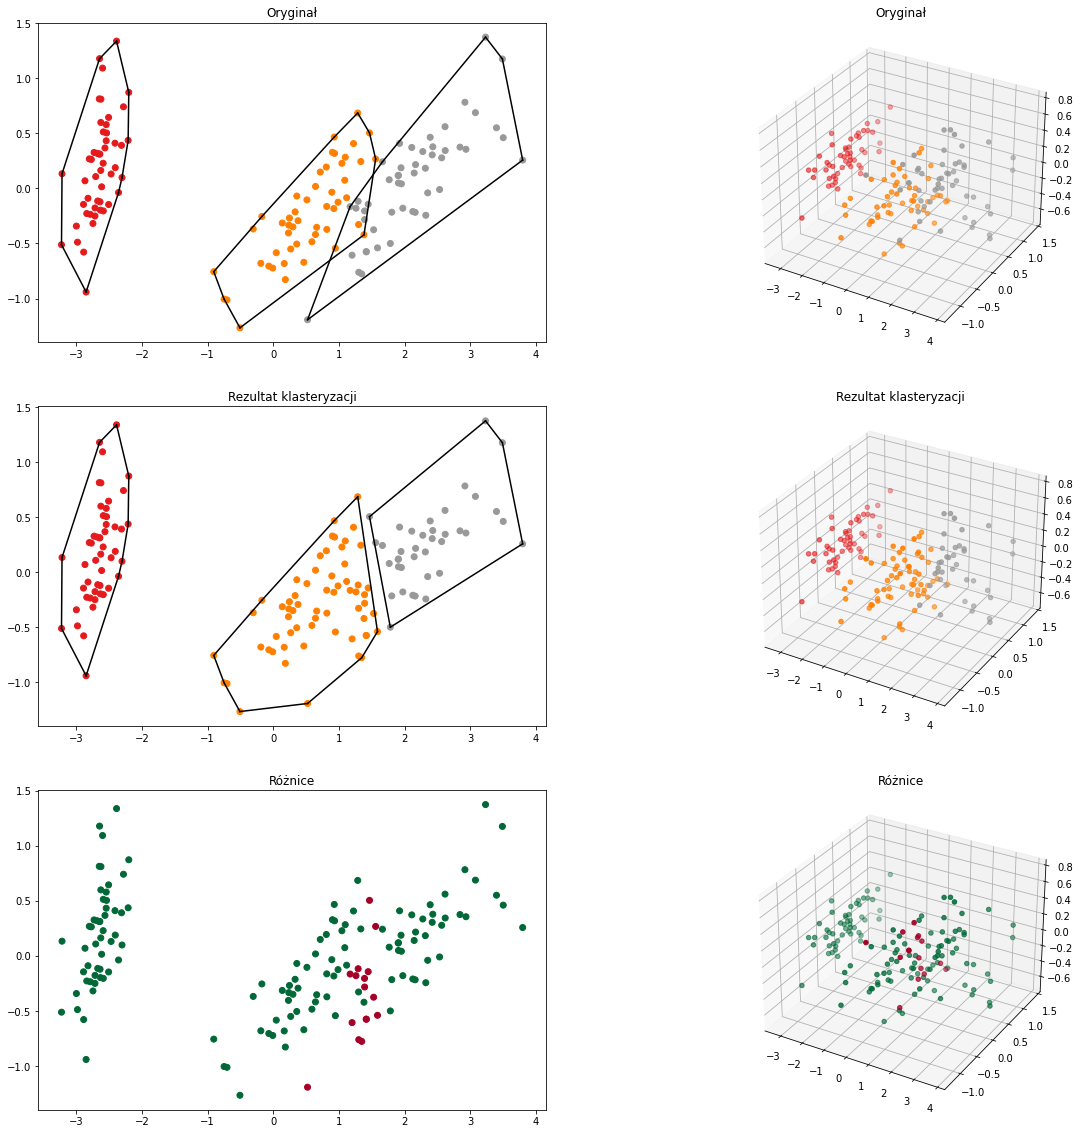

In [11]:
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import jaccard_score
from sklearn.decomposition import PCA

iris = datasets.load_iris()
X = iris.data
Y = iris.target
km = KMeans(n_clusters=3, random_state=0).fit(X)
Y_pred = km.predict(X)
Y_pred = find_perm(3, Y, Y_pred)
jaccard_scores["kmeans_sklearn"] = jaccard_score(Y, Y_pred, average=None)
plot_reduction(X, Y, Y_pred)

### `GMM`

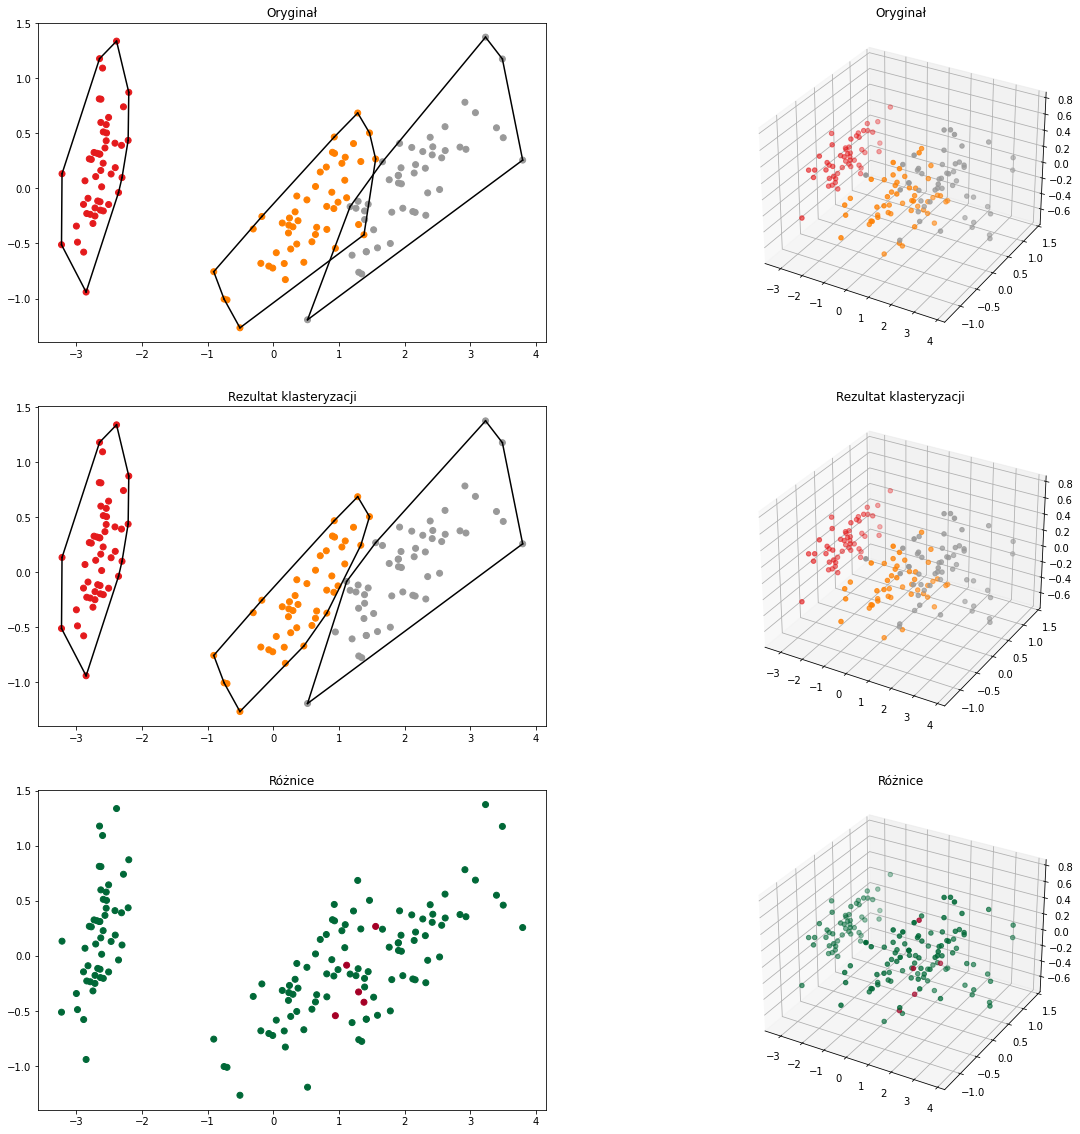

In [12]:
from sklearn.mixture import GaussianMixture

iris = datasets.load_iris()
X = iris.data
Y = iris.target
gm = GaussianMixture(n_components=3).fit(X)
Y_pred = gm.predict(X)
Y_pred = find_perm(3, Y, Y_pred)
jaccard_scores["gmm_sklearn"] = jaccard_score(Y, Y_pred, average=None)
plot_reduction(X, Y, Y_pred)

### `AgglomerativeClustering`

Metody aglomeracyjne działają iteracyjnie scalając próbki (grupy) w kolejne klastry tworząc hierarchię. Na samym końcu mamy jeden główny klaster.
Możemy dobierać liczbę iteracji już po stworzonej hierarchii. Łączy klasy najbardziej podobne zgodnie z daną metryką.


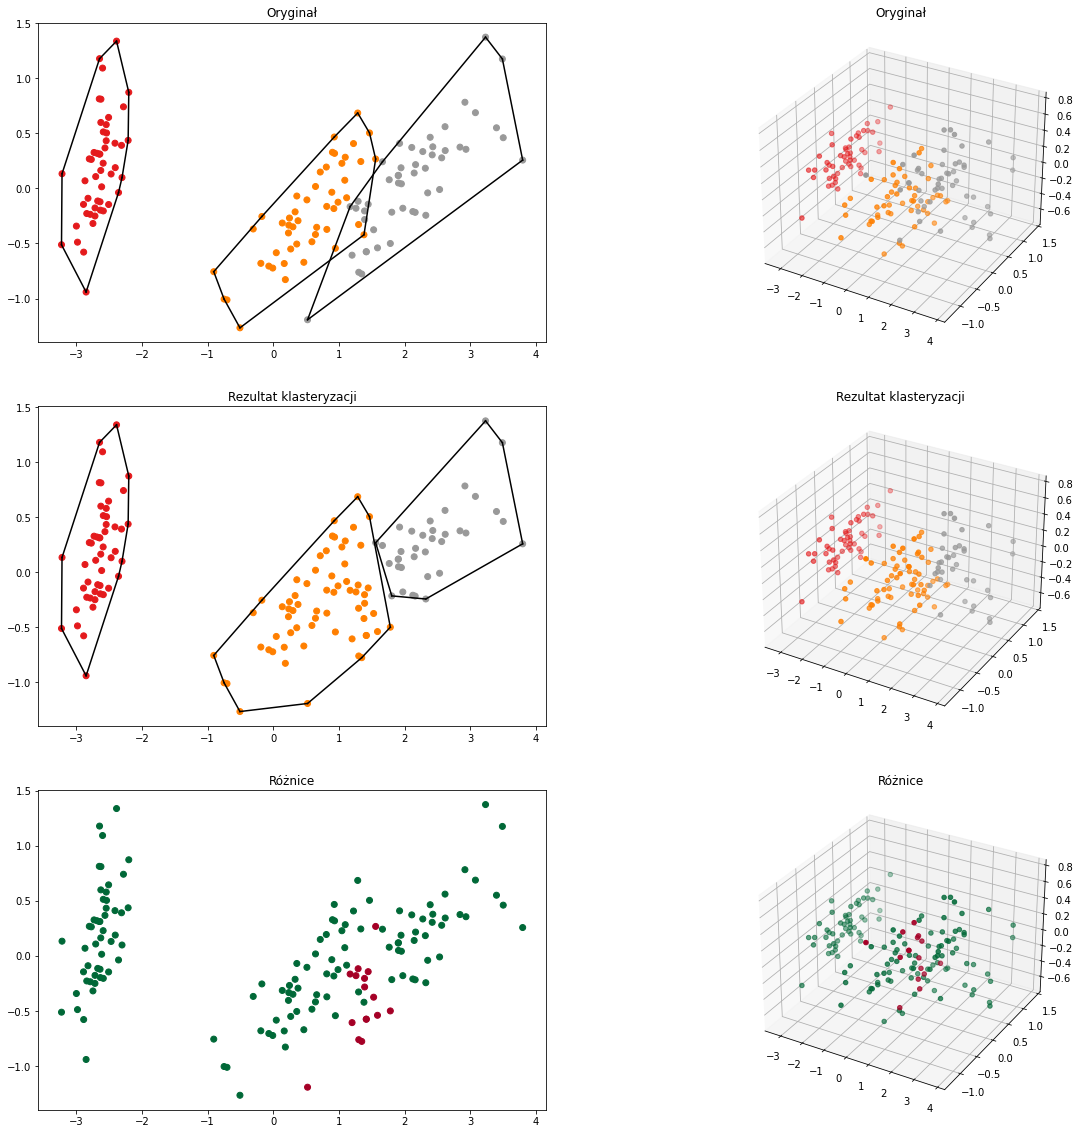

In [13]:
from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering

linkages = ["complete", "average", "single", "ward"]
iris = datasets.load_iris()
X = iris.data
Y = iris.target
    
for linkage in linkages:
    model = AgglomerativeClustering(n_clusters=3, linkage=linkage).fit(X)
    Y_pred = model.labels_
    Y_pred = find_perm(3, Y, Y_pred)
    jaccard_scores["agglomerative_"+linkage] = jaccard_score(Y, Y_pred, average=None)
    
plot_reduction(X, Y, Y_pred)

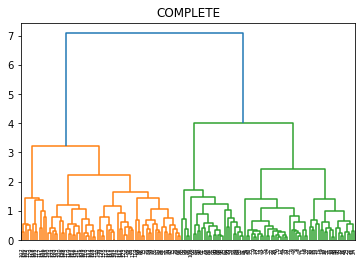

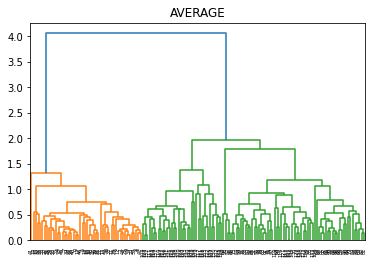

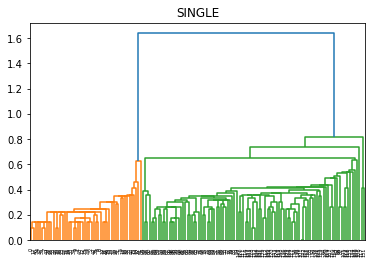

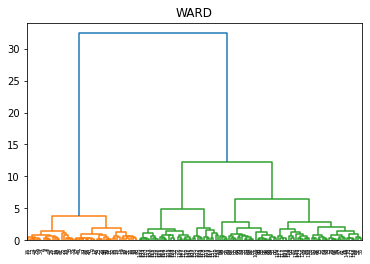

In [14]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
model = AgglomerativeClustering(n_clusters=None, distance_threshold=0, linkage='complete').fit(X)
plt.title('COMPLETE')
plot_dendrogram(model, truncate_mode='level')
plt.show()

model = AgglomerativeClustering(n_clusters=None, distance_threshold=0, linkage='average').fit(X)
plt.title('AVERAGE')
plot_dendrogram(model, truncate_mode='level')
plt.show()

model = AgglomerativeClustering(n_clusters=None, distance_threshold=0, linkage='single').fit(X)
plt.title('SINGLE')
plot_dendrogram(model, truncate_mode='level')
plt.show()

model = AgglomerativeClustering(n_clusters=None, distance_threshold=0, linkage='ward').fit(X)
plt.title('WARD')
plot_dendrogram(model, truncate_mode='level')
plt.show()

## Podsumowanie wyników

In [15]:
import pandas as pd
df = pd.DataFrame.from_dict(jaccard_scores, orient='index', columns=['klasa_1', 'klasa_2', 'klasa_3'])
df.sort_values(by=['klasa_1', 'klasa_2', 'klasa_3'], ascending=False)

,klasa_1,klasa_2,klasa_3
gmm_sklearn,1.0,0.900000,0.909091
agglomerative_average,1.0,0.781250,0.720000
agglomerative_ward,1.0,0.753846,0.686275
kmeans_sklearn,1.0,0.750000,0.692308
kmeans,1.0,0.734375,0.679245
agglomerative_complete,1.0,0.529412,0.671233
agglomerative_single,1.0,0.510204,0.040000


# Zbiór ZOO

In [16]:
from sklearn import preprocessing

df = pd.read_csv('../data/zoo.csv')
Y = df['type']
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)
X = df.drop(columns=['animal', 'type']).to_numpy().astype('int')

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

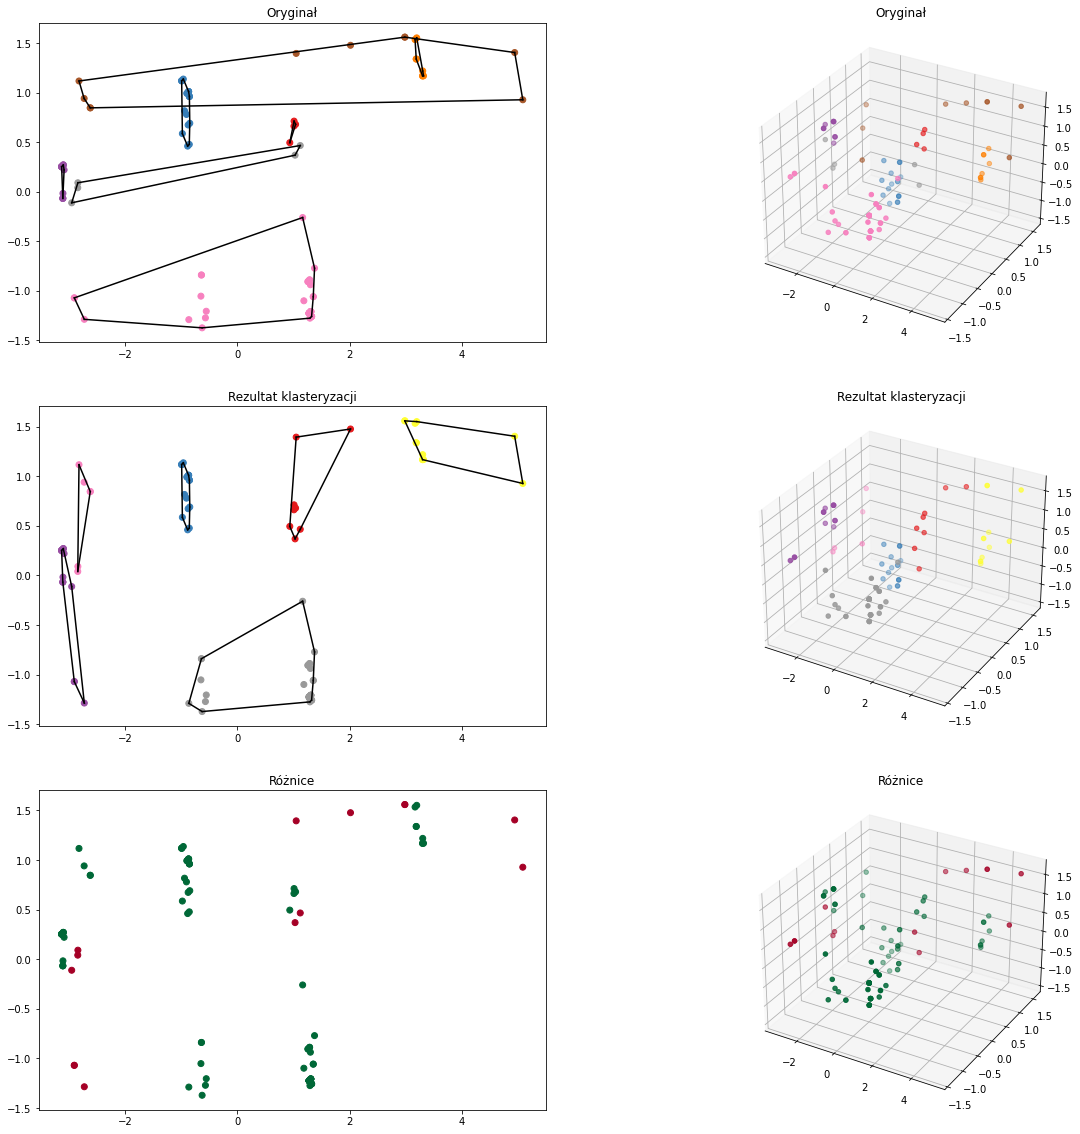

In [17]:
n_clusters = len(np.unique(Y))

# Agglomerative
linkages = ["complete", "average", "single", "ward"]

for linkage in linkages:
    Y_pred = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage).fit_predict(X)
    Y_pred = find_perm(n_clusters, Y, Y_pred)
    jaccard_scores["agglomerative_"+linkage] = jaccard_score(Y, Y_pred, average=None)
    
# GMM
gm = GaussianMixture(n_components=n_clusters).fit(X)
Y_pred = gm.predict(X)
Y_pred = find_perm(n_clusters, Y, Y_pred)
jaccard_scores["gmm_sklearn"] = jaccard_score(Y, Y_pred, average=None)

## K-Means sklearn
km = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
Y_pred = km.predict(X)
Y_pred = find_perm(n_clusters, Y, Y_pred)
jaccard_scores["kmeans_sklearn"] = jaccard_score(Y, Y_pred, average=None)
plot_reduction(X, Y, Y_pred)

# K-Means
Y_pred, _ = kmeans(X, n_clusters)
Y_pred = find_perm(n_clusters, Y, Y_pred)
jaccard_scores["kmeans"] = jaccard_score(Y, Y_pred, average=None)

## Podsumowanie wyników dla zbioru ZOO

In [18]:
import pandas as pd
df = pd.DataFrame.from_dict(jaccard_scores, orient='index', columns=list(le.classes_))
df

,amphibian,bird,fish,insect,invertebrate,mammal,reptile
kmeans,0.428571,0.800000,0.684211,0.666667,0.400000,0.727273,0.0
kmeans_sklearn,0.500000,1.000000,0.764706,0.666667,0.333333,0.926829,0.0
gmm_sklearn,0.500000,0.909091,0.650000,0.666667,0.000000,0.951220,0.0
agglomerative_complete,0.000000,1.000000,0.565217,1.000000,0.600000,0.808511,0.0
agglomerative_average,0.000000,1.000000,0.684211,0.666667,0.600000,0.808511,0.0
agglomerative_single,0.000000,1.000000,0.684211,0.000000,0.600000,0.644068,0.0
agglomerative_ward,0.571429,1.000000,0.812500,0.571429,0.307692,0.902439,0.0
